# Generation de Videos Educatives

**Module :** 04-Applications  
**Niveau :** Applications  
**Technologies :** moviepy, Pillow (text rendering), diffusers (optionnel), OpenAI API  
**Duree estimee :** 45 minutes  
**VRAM :** ~12 GB (optionnel, CPU possible pour l'essentiel)  

## Objectifs d'Apprentissage

- [ ] Generer des images de slides a partir de contenu textuel avec Pillow
- [ ] Creer des transitions animees entre slides avec moviepy
- [ ] Ajouter des overlays textuels et annotations sur la video
- [ ] Assembler une video educative complete avec timing par section
- [ ] (Optionnel) Ameliorer les visuels avec la generation d'images IA
- [ ] Exporter la video finale avec marqueurs de chapitres

## Prerequis

- Python 3.10+
- Notebooks 01-1 a 03-3 (fondations video, techniques avancees, orchestration)
- Packages : `moviepy`, `Pillow`, `numpy`, `matplotlib`
- Optionnel : `diffusers`, `torch` pour la generation d'images IA
- Optionnel : `openai` pour la generation de contenu via API

**Navigation** : [<< 03-3 ComfyUI Video Workflows](../03-Orchestration/03-3-ComfyUI-Video-Workflows.ipynb) | [04-2 Workflows Creatifs >>](04-2-Creative-Video-Workflows.ipynb)

In [1]:
# Parametres Papermill - JAMAIS modifier ce commentaire

# Configuration notebook
notebook_mode = "interactive"        # "interactive" ou "batch"
skip_widgets = False               # True pour mode batch MCP
debug_level = "INFO"

# Parametres video educative
slide_width = 1280                 # Largeur des slides en pixels
slide_height = 720                 # Hauteur des slides en pixels
slide_duration = 6                 # Duree par defaut d'un slide (secondes)
transition_duration = 1.0          # Duree des transitions (secondes)
output_fps = 30                    # FPS de la video finale
output_format = "mp4"              # Format de sortie

# Options de contenu
enable_ai_visuals = False          # Utiliser la generation d'images IA
enable_openai_content = False      # Generer le contenu avec OpenAI
save_results = True                # Sauvegarder les resultats

In [2]:
# Parameters
notebook_mode = "batch"
skip_widgets = True


In [3]:
# Setup environnement et imports
import os
import sys
import json
import time
import warnings
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Any, Optional, Tuple
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import logging

warnings.filterwarnings('ignore', category=DeprecationWarning)

# Resolution GENAI_ROOT
GENAI_ROOT = Path.cwd()
while GENAI_ROOT.name != 'GenAI' and len(GENAI_ROOT.parts) > 1:
    GENAI_ROOT = GENAI_ROOT.parent

HELPERS_PATH = GENAI_ROOT / 'shared' / 'helpers'
if HELPERS_PATH.exists():
    sys.path.insert(0, str(HELPERS_PATH.parent))
    try:
        from helpers.video_helpers import get_video_info, extract_frames, display_frame_grid
        print("Helpers video importes")
    except ImportError as e:
        print(f"Helpers video non disponibles ({e}) - mode autonome")

# Repertoire de sortie
OUTPUT_DIR = GENAI_ROOT / 'outputs' / 'video'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Configuration logging
logging.basicConfig(level=getattr(logging, debug_level))
logger = logging.getLogger('edu_video')

print(f"Generation de Videos Educatives")
print(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Mode : {notebook_mode}")
print(f"Slides : {slide_width}x{slide_height}, {slide_duration}s/slide")
print(f"Sortie : {OUTPUT_DIR}")

Helpers video importes
Generation de Videos Educatives
Date : 2026-02-26 08:11:01
Mode : batch
Slides : 1280x720, 6s/slide
Sortie : D:\Dev\CoursIA.worktrees\GenAI_Series\MyIA.AI.Notebooks\GenAI\outputs\video


In [4]:
# Chargement .env et verification des dependances
from dotenv import load_dotenv

current_path = Path.cwd()
found_env = False
for _ in range(4):
    env_path = current_path / '.env'
    if env_path.exists():
        load_dotenv(env_path)
        print(f"Fichier .env charge depuis : {env_path}")
        found_env = True
        break
    current_path = current_path.parent

if not found_env:
    print("Aucun fichier .env trouve")

# Verification des dependances
print("\n--- VERIFICATION DES DEPENDANCES ---")
print("=" * 40)

dependencies = {}

try:
    import moviepy.editor as mpy
    dependencies['moviepy'] = True
    print(f"moviepy : disponible")
except ImportError:
    dependencies['moviepy'] = False
    print(f"moviepy : NON INSTALLE (pip install moviepy)")

try:
    import imageio
    dependencies['imageio'] = True
    print(f"imageio : disponible")
except ImportError:
    dependencies['imageio'] = False
    print(f"imageio : NON INSTALLE (pip install imageio imageio-ffmpeg)")

try:
    import diffusers
    import torch
    dependencies['diffusers'] = True
    gpu_available = torch.cuda.is_available()
    print(f"diffusers : disponible (GPU: {gpu_available})")
except ImportError:
    dependencies['diffusers'] = False
    print(f"diffusers : NON INSTALLE (optionnel)")

try:
    import openai
    dependencies['openai'] = True
    print(f"openai : disponible")
except ImportError:
    dependencies['openai'] = False
    print(f"openai : NON INSTALLE (optionnel)")

available_count = sum(dependencies.values())
total_count = len(dependencies)
print(f"\nDependances disponibles : {available_count}/{total_count}")

Fichier .env charge depuis : D:\Dev\CoursIA.worktrees\GenAI_Series\MyIA.AI.Notebooks\GenAI\.env

--- VERIFICATION DES DEPENDANCES ---
moviepy : NON INSTALLE (pip install moviepy)
imageio : disponible


diffusers : disponible (GPU: False)


openai : disponible

Dependances disponibles : 3/4


## Section 1 : Definition du contenu educatif

La premiere etape de la creation d'une video educative est la definition du contenu.
Chaque slide est defini par un titre, un corps de texte, et optionnellement des points cles.
Cette structure permet de generer automatiquement les visuels et le timing.

In [5]:
# Definition du contenu educatif sous forme structuree
print("\n--- DEFINITION DU CONTENU EDUCATIF ---")
print("=" * 45)

# Structure du cours : liste de slides
course_content = [
    {
        "type": "title",
        "title": "Introduction au Machine Learning",
        "subtitle": "Concepts fondamentaux et applications",
        "duration": 4,
    },
    {
        "type": "content",
        "title": "Qu'est-ce que le Machine Learning ?",
        "bullets": [
            "Apprentissage a partir de donnees",
            "Amelioration avec l'experience",
            "Generalisation a de nouveaux cas",
            "Alternative a la programmation explicite",
        ],
        "duration": slide_duration,
    },
    {
        "type": "content",
        "title": "Types d'apprentissage",
        "bullets": [
            "Supervise : donnees etiquetees (classification, regression)",
            "Non supervise : decouverte de structures (clustering)",
            "Par renforcement : apprentissage par essai-erreur",
        ],
        "duration": slide_duration,
    },
    {
        "type": "content",
        "title": "Pipeline typique ML",
        "bullets": [
            "1. Collecte et preparation des donnees",
            "2. Selection et entrainement du modele",
            "3. Evaluation des performances",
            "4. Deploiement et monitoring",
        ],
        "duration": slide_duration,
    },
    {
        "type": "diagram",
        "title": "Architecture d'un reseau de neurones",
        "layers": [4, 6, 6, 3],
        "labels": ["Entree", "Cachee 1", "Cachee 2", "Sortie"],
        "duration": slide_duration + 2,
    },
    {
        "type": "content",
        "title": "Applications concretes",
        "bullets": [
            "Vision par ordinateur (detection d'objets)",
            "Traitement du langage naturel (traduction)",
            "Systemes de recommandation",
            "Vehicules autonomes",
        ],
        "duration": slide_duration,
    },
    {
        "type": "title",
        "title": "Merci !",
        "subtitle": "Questions et ressources supplementaires",
        "duration": 4,
    },
]

total_duration = sum(s["duration"] for s in course_content)
total_duration_with_transitions = total_duration + transition_duration * (len(course_content) - 1)

print(f"Nombre de slides : {len(course_content)}")
print(f"Duree contenu : {total_duration}s")
print(f"Duree avec transitions : {total_duration_with_transitions:.1f}s")
print(f"\nStructure du cours :")
for i, slide in enumerate(course_content):
    print(f"  Slide {i+1} [{slide['type']}] : {slide['title']} ({slide['duration']}s)")


--- DEFINITION DU CONTENU EDUCATIF ---
Nombre de slides : 7
Duree contenu : 40s
Duree avec transitions : 46.0s

Structure du cours :
  Slide 1 [title] : Introduction au Machine Learning (4s)
  Slide 2 [content] : Qu'est-ce que le Machine Learning ? (6s)
  Slide 3 [content] : Types d'apprentissage (6s)
  Slide 4 [content] : Pipeline typique ML (6s)
  Slide 5 [diagram] : Architecture d'un reseau de neurones (8s)
  Slide 6 [content] : Applications concretes (6s)
  Slide 7 [title] : Merci ! (4s)


## Section 2 : Generation des images de slides

Chaque slide est rendu sous forme d'image PNG avec Pillow.
Le rendu comprend un fond colore, le titre, les points cles et un pied de page.
Pour les slides de type "diagram", nous generons une visualisation specifique.


--- GENERATION DES IMAGES DE SLIDES ---
  Slide 1/7 genere : Introduction au Machine Learning
  Slide 2/7 genere : Qu'est-ce que le Machine Learning ?
  Slide 3/7 genere : Types d'apprentissage
  Slide 4/7 genere : Pipeline typique ML


  Slide 5/7 genere : Architecture d'un reseau de neurones
  Slide 6/7 genere : Applications concretes
  Slide 7/7 genere : Merci !

7 slides generes (1280x720)


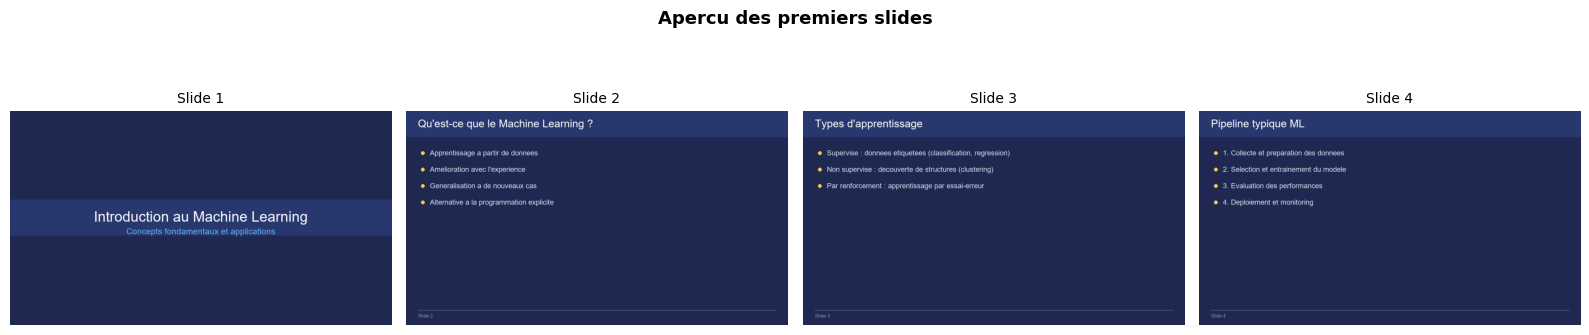

In [6]:
# Fonctions de rendu des slides avec Pillow
print("\n--- GENERATION DES IMAGES DE SLIDES ---")
print("=" * 45)

# Palette de couleurs professionnelle
COLORS = {
    "bg_primary": (30, 40, 80),       # Bleu fonce
    "bg_secondary": (40, 55, 110),    # Bleu moyen
    "text_title": (255, 255, 255),    # Blanc
    "text_body": (220, 225, 240),     # Gris clair
    "accent": (100, 180, 255),        # Bleu clair
    "bullet": (255, 200, 80),         # Jaune
    "footer": (150, 160, 190),        # Gris
}


def render_title_slide(slide: dict, width: int, height: int) -> Image.Image:
    """Rendu d'un slide de titre (ouverture/fermeture)."""
    img = Image.new('RGB', (width, height), COLORS['bg_primary'])
    draw = ImageDraw.Draw(img)
    
    # Bande decorative
    draw.rectangle([0, height // 2 - 60, width, height // 2 + 60],
                   fill=COLORS['bg_secondary'])
    
    # Titre principal centre
    title = slide['title']
    try:
        font_title = ImageFont.truetype("arial.ttf", 48)
        font_sub = ImageFont.truetype("arial.ttf", 28)
    except (OSError, IOError):
        font_title = ImageFont.load_default()
        font_sub = ImageFont.load_default()
    
    bbox = draw.textbbox((0, 0), title, font=font_title)
    tw = bbox[2] - bbox[0]
    draw.text(((width - tw) // 2, height // 2 - 30), title,
              fill=COLORS['text_title'], font=font_title)
    
    # Sous-titre
    if 'subtitle' in slide:
        bbox_sub = draw.textbbox((0, 0), slide['subtitle'], font=font_sub)
        sw = bbox_sub[2] - bbox_sub[0]
        draw.text(((width - sw) // 2, height // 2 + 30), slide['subtitle'],
                  fill=COLORS['accent'], font=font_sub)
    
    return img


def render_content_slide(slide: dict, width: int, height: int,
                         slide_num: int) -> Image.Image:
    """Rendu d'un slide de contenu avec titre et points cles."""
    img = Image.new('RGB', (width, height), COLORS['bg_primary'])
    draw = ImageDraw.Draw(img)
    
    # En-tete
    draw.rectangle([0, 0, width, 90], fill=COLORS['bg_secondary'])
    
    try:
        font_title = ImageFont.truetype("arial.ttf", 36)
        font_body = ImageFont.truetype("arial.ttf", 24)
        font_footer = ImageFont.truetype("arial.ttf", 16)
    except (OSError, IOError):
        font_title = ImageFont.load_default()
        font_body = ImageFont.load_default()
        font_footer = ImageFont.load_default()
    
    # Titre
    draw.text((40, 25), slide['title'], fill=COLORS['text_title'], font=font_title)
    
    # Points cles avec puces
    y_offset = 130
    line_spacing = 55
    for bullet in slide.get('bullets', []):
        # Puce decorative
        draw.ellipse([50, y_offset + 8, 62, y_offset + 20], fill=COLORS['bullet'])
        # Texte
        draw.text((80, y_offset), bullet, fill=COLORS['text_body'], font=font_body)
        y_offset += line_spacing
    
    # Pied de page
    draw.line([40, height - 50, width - 40, height - 50], fill=COLORS['footer'], width=1)
    draw.text((40, height - 40), f"Slide {slide_num}",
              fill=COLORS['footer'], font=font_footer)
    
    return img


def render_diagram_slide(slide: dict, width: int, height: int,
                         slide_num: int) -> Image.Image:
    """Rendu d'un slide avec diagramme de reseau de neurones."""
    # Creer le diagramme avec matplotlib
    fig, ax = plt.subplots(1, 1, figsize=(width / 100, height / 100), dpi=100)
    fig.patch.set_facecolor(np.array(COLORS['bg_primary']) / 255.0)
    ax.set_facecolor(np.array(COLORS['bg_primary']) / 255.0)
    
    layers = slide['layers']
    labels = slide.get('labels', [f'Couche {i}' for i in range(len(layers))])
    n_layers = len(layers)
    max_neurons = max(layers)
    
    # Dessiner les neurones et connexions
    positions = {}
    for l_idx, n_neurons in enumerate(layers):
        x = l_idx / (n_layers - 1) if n_layers > 1 else 0.5
        for n_idx in range(n_neurons):
            y = (n_idx - n_neurons / 2 + 0.5) / max_neurons
            positions[(l_idx, n_idx)] = (x, y)
    
    # Connexions
    for l_idx in range(n_layers - 1):
        for n1 in range(layers[l_idx]):
            for n2 in range(layers[l_idx + 1]):
                p1 = positions[(l_idx, n1)]
                p2 = positions[(l_idx + 1, n2)]
                ax.plot([p1[0], p2[0]], [p1[1], p2[1]],
                        color=np.array(COLORS['footer']) / 255.0, alpha=0.3, linewidth=0.5)
    
    # Neurones
    for (l_idx, n_idx), (x, y) in positions.items():
        color = np.array(COLORS['accent']) / 255.0 if l_idx in [0, n_layers - 1] else np.array(COLORS['bullet']) / 255.0
        ax.scatter(x, y, s=200, c=[color], zorder=5, edgecolors='white', linewidths=0.5)
    
    # Labels des couches
    for l_idx, label in enumerate(labels):
        x = l_idx / (n_layers - 1) if n_layers > 1 else 0.5
        ax.text(x, -0.55, label, ha='center', va='top',
                color=np.array(COLORS['text_body']) / 255.0, fontsize=11)
    
    ax.set_title(slide['title'], color='white', fontsize=16, pad=20, fontweight='bold')
    ax.set_xlim(-0.15, 1.15)
    ax.set_ylim(-0.7, 0.7)
    ax.axis('off')
    
    # Convertir figure en image PIL
    fig.canvas.draw()
    buf = fig.canvas.buffer_rgba()
    img = Image.frombuffer('RGBA', fig.canvas.get_width_height(), buf, 'raw', 'RGBA', 0, 1)
    img = img.convert('RGB').resize((width, height), Image.LANCZOS)
    plt.close(fig)
    
    return img


# Generer tous les slides
slide_images = []
for i, slide in enumerate(course_content):
    if slide['type'] == 'title':
        img = render_title_slide(slide, slide_width, slide_height)
    elif slide['type'] == 'diagram':
        img = render_diagram_slide(slide, slide_width, slide_height, i + 1)
    else:
        img = render_content_slide(slide, slide_width, slide_height, i + 1)
    slide_images.append(img)
    print(f"  Slide {i+1}/{len(course_content)} genere : {slide['title']}")

print(f"\n{len(slide_images)} slides generes ({slide_width}x{slide_height})")

# Apercu des slides
n_preview = min(4, len(slide_images))
fig, axes = plt.subplots(1, n_preview, figsize=(16, 4))
for i, ax in enumerate(axes):
    ax.imshow(slide_images[i])
    ax.set_title(f"Slide {i+1}", fontsize=10)
    ax.axis('off')
plt.suptitle("Apercu des premiers slides", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### Interpretation : Generation des slides

| Aspect | Valeur | Signification |
|--------|--------|---------------|
| Rendu Pillow | CPU uniquement | Pas besoin de GPU pour le texte et les formes |
| Diagrammes | matplotlib -> PIL | Les graphiques scientifiques sont convertis en images |
| Polices | TrueType avec fallback | Fonctionne meme sans polices systeme installees |
| Palette | Tons bleu fonce | Palette professionnelle a fort contraste |

**Points cles** :
1. La separation contenu/rendu permet de modifier le style sans toucher au contenu
2. Chaque type de slide (titre, contenu, diagramme) a son propre moteur de rendu
3. Les diagrammes matplotlib offrent une grande flexibilite pour les schemas techniques

## Section 3 : Transitions animees entre slides

Les transitions entre slides rendent la video plus fluide et professionnelle.
Nous implementons ici un fondu enchaine (cross-dissolve) entre chaque paire de slides consecutifs.

In [7]:
# Creation de transitions animees entre slides
print("\n--- CREATION DES TRANSITIONS ---")
print("=" * 40)


def create_crossfade_frames(img_from: Image.Image, img_to: Image.Image,
                            duration: float, fps: int) -> List[np.ndarray]:
    """
    Cree les frames d'un fondu enchaine entre deux images.
    
    Args:
        img_from: Image de depart
        img_to: Image d'arrivee
        duration: Duree de la transition en secondes
        fps: Images par seconde
    
    Returns:
        Liste de frames numpy (H, W, 3)
    """
    n_frames = int(duration * fps)
    arr_from = np.array(img_from, dtype=np.float32)
    arr_to = np.array(img_to, dtype=np.float32)
    
    frames = []
    for i in range(n_frames):
        alpha = i / max(n_frames - 1, 1)
        # Interpolation lineaire
        blended = (1 - alpha) * arr_from + alpha * arr_to
        frames.append(blended.astype(np.uint8))
    
    return frames


def create_slide_with_text_animation(slide_img: Image.Image, slide_data: dict,
                                     duration: float, fps: int) -> List[np.ndarray]:
    """
    Cree les frames d'un slide avec apparition progressive du texte.
    Les premiers 20% de la duree montrent un fondu d'apparition.
    """
    n_frames = int(duration * fps)
    arr = np.array(slide_img)
    frames = []
    
    fade_in_frames = int(n_frames * 0.15)  # 15% pour le fade-in
    
    for i in range(n_frames):
        if i < fade_in_frames:
            # Progressivement reveler depuis un fond sombre
            alpha = i / max(fade_in_frames - 1, 1)
            dark = np.full_like(arr, COLORS['bg_primary'])
            frame = ((1 - alpha) * dark + alpha * arr).astype(np.uint8)
        else:
            frame = arr.copy()
        frames.append(frame)
    
    return frames


# Assembler toutes les frames avec transitions
all_frames = []
total_expected = 0

for i, (slide_img, slide_data) in enumerate(zip(slide_images, course_content)):
    # Frames du slide
    slide_frames = create_slide_with_text_animation(
        slide_img, slide_data, slide_data['duration'], output_fps
    )
    all_frames.extend(slide_frames)
    
    # Transition vers le slide suivant
    if i < len(slide_images) - 1:
        transition_frames = create_crossfade_frames(
            slide_img, slide_images[i + 1], transition_duration, output_fps
        )
        all_frames.extend(transition_frames)
    
    print(f"  Slide {i+1} : {len(slide_frames)} frames" +
          (f" + {len(transition_frames)} transition" if i < len(slide_images) - 1 else ""))

print(f"\nTotal frames assemblees : {len(all_frames)}")
print(f"Duree estimee : {len(all_frames) / output_fps:.1f}s")
print(f"Memoire estimee : ~{len(all_frames) * slide_width * slide_height * 3 / 1024 / 1024:.0f} MB")


--- CREATION DES TRANSITIONS ---


  Slide 1 : 120 frames + 30 transition


  Slide 2 : 180 frames + 30 transition


  Slide 3 : 180 frames + 30 transition


  Slide 4 : 180 frames + 30 transition


  Slide 5 : 240 frames + 30 transition


  Slide 6 : 180 frames + 30 transition


  Slide 7 : 120 frames

Total frames assemblees : 1380
Duree estimee : 46.0s
Memoire estimee : ~3639 MB


### Interpretation : Transitions

| Type de transition | Technique | Duree typique |
|-------------------|-----------|---------------|
| Fondu enchaine | Interpolation lineaire des pixels | 0.5 - 1.5s |
| Fade-in depuis noir | Interpolation avec fond sombre | 0.3 - 0.8s |
| Apparition du texte | Masquage progressif | Variable |

**Points cles** :
1. Les transitions sont generees frame par frame en memoire avant l'encodage
2. La consommation memoire est proportionnelle au nombre total de frames
3. Pour de longues videos, il faudrait un encodage en streaming plutot qu'en memoire

## Section 4 : Overlay texte et annotations

Nous ajoutons maintenant des annotations dynamiques : barre de progression,
numero de chapitre, et indicateur de timing.

In [8]:
# Ajout des overlays dynamiques sur les frames
print("\n--- AJOUT DES OVERLAYS DYNAMIQUES ---")
print("=" * 45)


def add_progress_bar(frame: np.ndarray, progress: float,
                     bar_height: int = 6) -> np.ndarray:
    """Ajoute une barre de progression en bas de la frame."""
    h, w = frame.shape[:2]
    result = frame.copy()
    
    # Fond de la barre
    result[h - bar_height:h, :] = [40, 40, 60]
    
    # Progression
    fill_width = int(w * progress)
    result[h - bar_height:h, :fill_width] = COLORS['accent']
    
    return result


def add_chapter_indicator(frame: np.ndarray, chapter_name: str,
                          frame_idx: int, total_frames: int) -> np.ndarray:
    """Ajoute un indicateur de chapitre et timestamp."""
    img = Image.fromarray(frame)
    draw = ImageDraw.Draw(img)
    
    try:
        font_small = ImageFont.truetype("arial.ttf", 14)
    except (OSError, IOError):
        font_small = ImageFont.load_default()
    
    timestamp = f"{frame_idx / output_fps:.1f}s / {total_frames / output_fps:.1f}s"
    
    # Fond semi-transparent pour le texte (rectangle sombre)
    h, w = frame.shape[:2]
    draw.rectangle([w - 200, 10, w - 10, 55], fill=(20, 25, 50))
    draw.text((w - 190, 15), chapter_name[:25], fill=COLORS['accent'], font=font_small)
    draw.text((w - 190, 33), timestamp, fill=COLORS['footer'], font=font_small)
    
    return np.array(img)


# Appliquer les overlays a toutes les frames
total_frames = len(all_frames)

# Calculer les limites de chaque chapitre (en frames)
chapter_boundaries = []
cumulative = 0
for i, slide in enumerate(course_content):
    start = cumulative
    end = cumulative + int(slide['duration'] * output_fps)
    chapter_boundaries.append((start, end, slide['title']))
    cumulative = end + int(transition_duration * output_fps)

print(f"Application des overlays sur {total_frames} frames...")
start_time = time.time()

for f_idx in range(total_frames):
    progress = f_idx / max(total_frames - 1, 1)
    
    # Determiner le chapitre courant
    current_chapter = "Transition"
    for (c_start, c_end, c_name) in chapter_boundaries:
        if c_start <= f_idx < c_end:
            current_chapter = c_name
            break
    
    # Appliquer les overlays
    all_frames[f_idx] = add_progress_bar(all_frames[f_idx], progress)
    all_frames[f_idx] = add_chapter_indicator(
        all_frames[f_idx], current_chapter, f_idx, total_frames
    )

overlay_time = time.time() - start_time
print(f"Overlays appliques en {overlay_time:.2f}s")
print(f"Vitesse : {total_frames / overlay_time:.0f} frames/s")


--- AJOUT DES OVERLAYS DYNAMIQUES ---
Application des overlays sur 1380 frames...


Overlays appliques en 14.31s
Vitesse : 96 frames/s


## Section 5 : Assemblage et export de la video finale

Toutes les frames sont pretes. Nous les encodons maintenant en fichier MP4
avec imageio et le codec H.264. Un apercu visuel confirme le resultat.


--- EXPORT VIDEO EDUCATIVE ---


Video exportee : educational_video.mp4
  Resolution : 1280x720
  FPS : 30
  Duree : 46.0s
  Taille : 0.92 MB
  Temps d'export : 3.21s
  Vitesse encodage : 430 frames/s


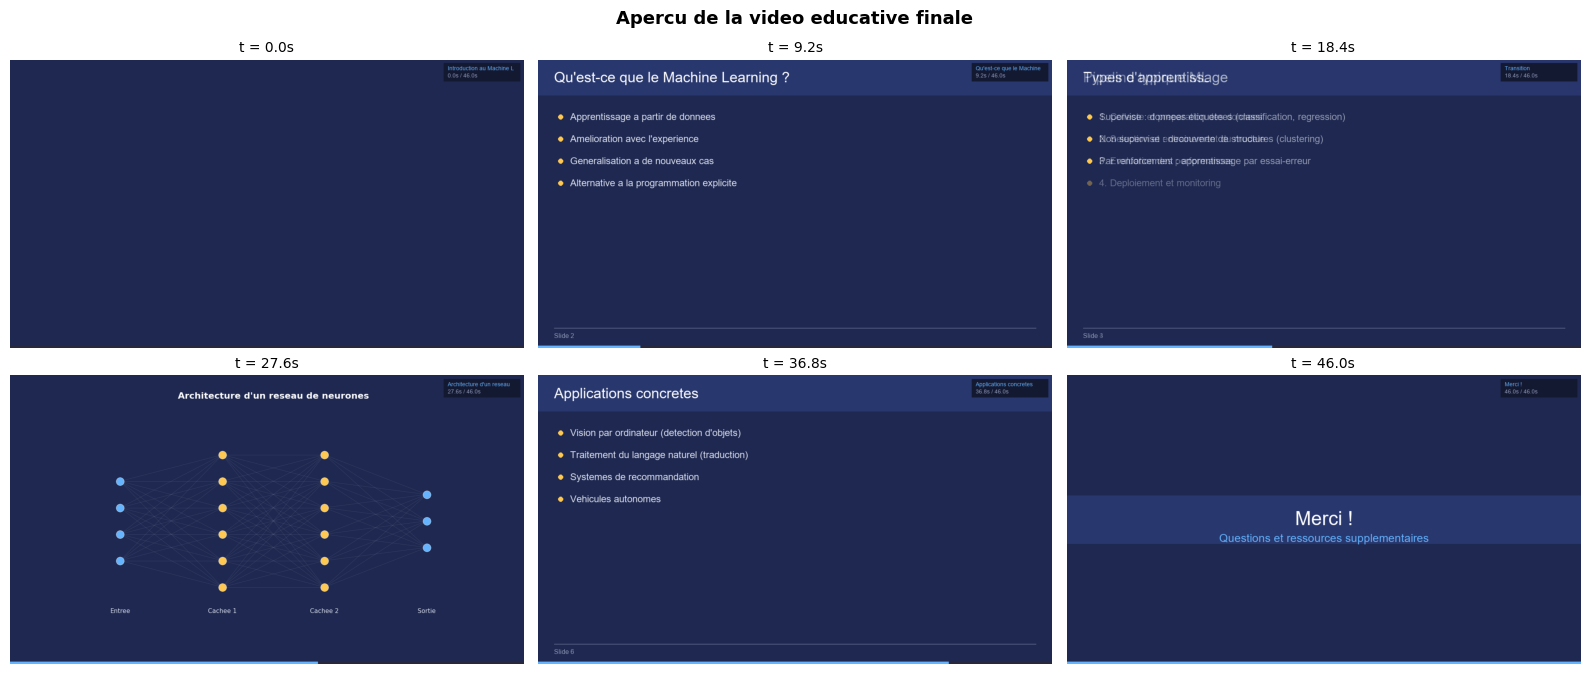


Marqueurs de chapitres :
Chapitre                                         Debut      Fin
-----------------------------------------------------------------
  Introduction au Machine Learning               0.0s    4.0s
  Qu'est-ce que le Machine Learning ?            5.0s   11.0s
  Types d'apprentissage                         12.0s   18.0s
  Pipeline typique ML                           19.0s   25.0s
  Architecture d'un reseau de neurones          26.0s   34.0s
  Applications concretes                        35.0s   41.0s
  Merci !                                       42.0s   46.0s


In [9]:
# Export de la video educative finale
print("\n--- EXPORT VIDEO EDUCATIVE ---")
print("=" * 40)

output_path = OUTPUT_DIR / f"educational_video.{output_format}"

if dependencies.get('imageio', False):
    start_time = time.time()
    
    writer = imageio.get_writer(
        str(output_path), fps=output_fps, codec='libx264',
        output_params=['-crf', '23', '-preset', 'medium']
    )
    for frame in all_frames:
        writer.append_data(frame)
    writer.close()
    
    export_time = time.time() - start_time
    file_size_mb = output_path.stat().st_size / (1024 * 1024)
    
    print(f"Video exportee : {output_path.name}")
    print(f"  Resolution : {slide_width}x{slide_height}")
    print(f"  FPS : {output_fps}")
    print(f"  Duree : {len(all_frames) / output_fps:.1f}s")
    print(f"  Taille : {file_size_mb:.2f} MB")
    print(f"  Temps d'export : {export_time:.2f}s")
    print(f"  Vitesse encodage : {len(all_frames) / export_time:.0f} frames/s")
    
    # Apercu de frames extraites de la video finale
    preview_indices = np.linspace(0, len(all_frames) - 1, 6, dtype=int)
    fig, axes = plt.subplots(2, 3, figsize=(16, 7))
    for ax, idx in zip(axes.flatten(), preview_indices):
        ax.imshow(all_frames[idx])
        ax.set_title(f"t = {idx / output_fps:.1f}s", fontsize=10)
        ax.axis('off')
    plt.suptitle("Apercu de la video educative finale", fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("imageio non disponible - export impossible")

# Generer les marqueurs de chapitres
print(f"\nMarqueurs de chapitres :")
print(f"{'Chapitre':<45} {'Debut':>8} {'Fin':>8}")
print("-" * 65)
for (start, end, name) in chapter_boundaries:
    t_start = start / output_fps
    t_end = end / output_fps
    print(f"  {name:<43} {t_start:>6.1f}s {t_end:>6.1f}s")

### Interpretation : Video educative

| Metrique | Valeur | Signification |
|----------|--------|---------------|
| Resolution | 1280x720 | HD standard, bon compromis qualite/taille |
| Codec H.264 CRF 23 | Compression visuelle | Qualite bonne avec taille raisonnable |
| Chapitres | Metadata temporelle | Permet la navigation dans la video |
| Barre de progression | Overlay dynamique | Repere visuel pour le spectateur |

**Points cles** :
1. Le parametre CRF (Constant Rate Factor) controle le compromis qualite/taille
2. Les marqueurs de chapitres facilitent la navigation dans les longues videos
3. L'approche frame-par-frame en memoire fonctionne pour les courtes videos (<5 min)

In [10]:
# Mode interactif - Personnalisation du contenu
if notebook_mode == "interactive" and not skip_widgets:
    print("\n--- MODE INTERACTIF ---")
    print("=" * 40)
    print("Vous pouvez modifier le contenu du cours et regenerer la video.")
    print("(Laissez vide pour passer)")
    
    try:
        custom_title = input("\nTitre du cours (ou vide) : ").strip()
        
        if custom_title:
            print(f"Regeneration avec le titre : {custom_title}")
            course_content[0]['title'] = custom_title
            print("Relancez les cellules de generation pour appliquer le changement.")
        else:
            print("Mode interactif ignore")
    
    except (KeyboardInterrupt, EOFError):
        print("Mode interactif interrompu")
    except Exception as e:
        error_type = type(e).__name__
        if "StdinNotImplemented" in error_type:
            print("Mode interactif non disponible (execution automatisee)")
        else:
            print(f"Erreur : {error_type}")
else:
    print("Mode batch - Interface interactive desactivee")

Mode batch - Interface interactive desactivee


In [11]:
# Statistiques de session
print("\n--- STATISTIQUES DE SESSION ---")
print("=" * 40)

print(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Mode : {notebook_mode}")
print(f"Slides generes : {len(slide_images)}")
print(f"Frames totales : {len(all_frames)}")
print(f"Duree video : {len(all_frames) / output_fps:.1f}s")
print(f"Resolution : {slide_width}x{slide_height} @ {output_fps}fps")

if save_results and OUTPUT_DIR.exists():
    generated_files = list(OUTPUT_DIR.glob('educational_*'))
    print(f"\nFichiers generes ({len(generated_files)}) :")
    for f in sorted(generated_files):
        size_kb = f.stat().st_size / 1024
        print(f"  {f.name} ({size_kb:.1f} KB)")

print(f"\nDependances utilisees :")
for dep, available in dependencies.items():
    status = "utilisee" if available else "non disponible"
    print(f"  {dep} : {status}")

print(f"\n--- PROCHAINES ETAPES ---")
print(f"1. Notebook 04-2 : Workflows Video Creatifs (style transfer, music video)")
print(f"2. Notebook 04-3 : Sora API - Generation Video Cloud")
print(f"3. Notebook 04-4 : Pipeline Video de Production (pipeline complet)")

print(f"\nNotebook 04-1 Educational Video Generation termine - {datetime.now().strftime('%H:%M:%S')}")


--- STATISTIQUES DE SESSION ---
Date : 2026-02-26 08:11:33
Mode : batch
Slides generes : 7
Frames totales : 1380
Duree video : 46.0s
Resolution : 1280x720 @ 30fps

Fichiers generes (1) :
  educational_video.mp4 (937.2 KB)

Dependances utilisees :
  moviepy : non disponible
  imageio : utilisee
  diffusers : utilisee
  openai : utilisee

--- PROCHAINES ETAPES ---
1. Notebook 04-2 : Workflows Video Creatifs (style transfer, music video)
2. Notebook 04-3 : Sora API - Generation Video Cloud
3. Notebook 04-4 : Pipeline Video de Production (pipeline complet)

Notebook 04-1 Educational Video Generation termine - 08:11:33
